# Crank-Nicolson Algorithm for Numerical Physics
The Crank-Nicolson algorithm allows one to solve parabolic PDEs implictly by
discretizing them via 2-point and 3-point formulas for first and second order
derivatives, respectively.
In general, the formula makes use of operators in that they are defined by
how they affect the discretized functions. The formula derived for this class
of problems (TDSE) is: $$ \psi_i^n+1 = (2-P)^{-1}P\psi_i^n $$

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import NumMethods as nm
from scipy import integrate

## Solving the time-dependent Schrodinger equation for a free particle

This code solves the time-dependent Schrodinger equation for a free particle using the Crank-Nicolson method. In the free particle model, the potential is 0. 

In the Crank-Nicholson method, the Schrodinger equation reduces to $ \psi_i^n+1 = (2-P)^{-1}P\psi_i^n $ 

where $\psi$ is the wavefunction and $P$ is the tridiagonal matrix containing the Hamiltonian $H=p^2/2m$

In [10]:
L=10 # Width being solved over
N=1000 # Number of space points
x=np.linspace(-L/2,L/2,N) # Grid of space points
sigma=0.1 # Width of wavefunction
p0=2 # Initial momentum

In [11]:
# Initial wavefunction
divF=1/((2*np.pi)**0.25*(sigma**1/2))
wfxn=np.exp(1j*p0*x)*np.exp((-x**2)/((2*sigma)**2))*divF

# Finding Normalization Constant
S=nm.simpson(N,x,wfxn*np.conj(wfxn),-L/2,L/2)
A=1/np.sqrt(abs(S))
print("Normalization constant:",np.real(A))

# New wavefunction:
wfxn=A*wfxn

print("Checking if wfxn is normalized... should be 1.")
S=nm.simpson(N,x,wfxn*np.conj(wfxn),-L/2,L/2)
print("Probability:",np.real(S))

Normalization constant: 0.15811388300841897
Checking if wfxn is normalized... should be 1.
Probability: 1.0


Expectation value of T, <T>: 11.554863914751074
Expectation value of H, <H>: 11.554863914751074


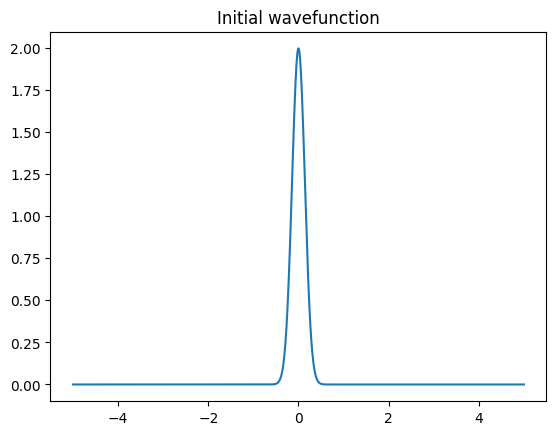

In [12]:
## Finding <H> by doing <T> ##

## Expectation value of momentum squared ##
# Now doing <T>, which is just <p^2>*0.5 = -1*<d^2/dx^2>*0.5 in atomic units

d2wfxn=np.zeros(N,dtype=complex) # allocating memory
d2wfxn=nm.three_point_two(N,x,wfxn,-L/2,L/2) # calculating 2nd derivative of wfxn

exp_T=np.real(nm.simpson(N-2,x[1:N-1],wfxn[1:N-1]*d2wfxn[1:N-1],-L/2,L/2)*-0.5)
print("Expectation value of T, <T>:",exp_T)
print("Expectation value of H, <H>:",exp_T)

#%% Finding smallest "wavelength" for spatial grid spacing in CN solution
plt.plot(x,np.abs(wfxn))
plt.title('Initial wavefunction')
plt.show()
nt=100
t=np.linspace(0,50,nt)

h=sigma # h < (smallest wavelength)/100

# Finding smallest time period for temporal grid spacing in CN solution
# Characteristic time period T=2*pi/exp_H, because E=hbar*w

T=2*np.pi/exp_T # 

tau = (t[-1]/nt)/10 # tau < T/10

Defining wavefunction to be evolved over time

In [13]:
g = (tau/h**2)*0.5j # Constants bunched together

V = np.zeros(N) # Free particle potential

B = -2*g-1.0j*tau*V+1

lower_diag = np.ones(N-1)*g; 
main_diag = B; 
upper_diag = np.ones(N-1)*g

P = nm.tridiag(lower_diag,main_diag,upper_diag)
Q = np.linalg.inv(2*np.identity(N)-P)

R=np.matmul(Q,P)

wfxn_sol = np.zeros([len(x),len(t)],dtype=complex)
wfxn_sol[:,0] = wfxn

Time evolution of wavefunction

In [14]:
for k in range(len(t)-1):
    wfxn_sol[:,k+1]=R.dot(wfxn_sol[:,k])

Checking if wavefunction is normalized... should be 1.
Probability: 0.9999999999999774


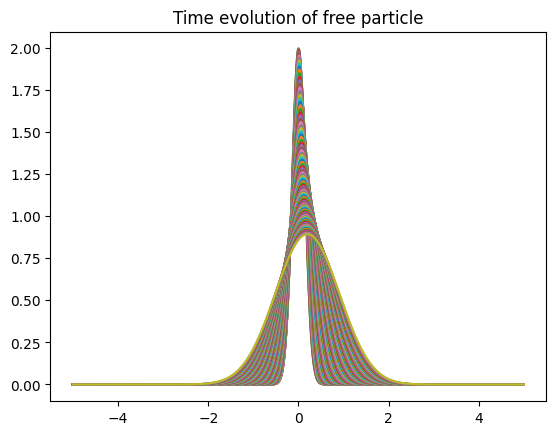

In [15]:
for j in range(len(t)-1):
    plt.plot(x,np.abs(wfxn_sol[:,j]))
    # plt.draw()
    plt.title('Time evolution of free particle')
    # plt.show()
# plt.show()
print("Checking if wavefunction is normalized... should be 1.")
S=nm.simpson(N,x,wfxn_sol[:,-1]*np.conj(wfxn_sol[:,-1]),-L/2,L/2)
print("Probability:",np.real(S))

## Solving parabolic-type PDEs via the Crank-Nicolson method. 
The Schrodinger equation is used to test the code, and the harmonic oscillator 
is used as a potential. 

This code can solve time dependent and time-independent QHO potentials by 
editing the value of the angular frequency. If statements are used to decide
how to proceed with the CN algorithm. If a time-independent potential is to
be used, please edit the w variable so that it is an integer and not an array.
If a time-dependent potential is to be used, please edit the w variable so that
it is an array and not an integer.

In [16]:
# CN_TDSE: Outputs solution to a parabolic PDE provided it follows the following
#     format: df/dt=d^2f/dx^2-Vf, where f is the function to be solved for and
#     V is some potential that varies in space and in time.
#     The output is a complex matrix containing a temporal and spatial dimension. 
#     V is a real matrix with temporal and/or space dimensions, wfxn is a complex
#     array of the wavefunction at time t=0, tau and h are the time and space
#     steps, respectively, t and x are the (real) temporal and spatial ranges being
#     solved over and N is the number of grid points.
def CN_TDSE(V,wfxn,tau,h,t,x,N):
    g=(tau/h**2)*0.5j # Constants bunched together
    
    # Equation to solve: psi_i^n+1 = inv(mat(2)-P)*P*psi_i^n
    # mat(2) is an identity matrix of 2s
    B=-2*g-1.0j*tau*V+1
    
    # Constructing elements of P matrix
    lower_diag = np.ones(N-1)*g; 
    main_diag = B; 
    upper_diag = np.ones(N-1)*g
    
    # Constructing P matrix
    P = nm.tridiag(lower_diag,main_diag,upper_diag)
    
    # Constructing A matrix 
    Q = np.linalg.inv(2*np.identity(N)-P)
    
    R=np.matmul(Q,P)# Multiplying the Q and P matrices together to be used in CN
    
    # Initializing wavefunction
    wfxn_sol=np.zeros([len(x),len(t)],dtype=complex)
    wfxn_sol[:,0]=wfxn
    
    # Solving TDSE by CN algorithm
    for k in range(len(t)-1):
        wfxn_sol[:,k+1]=R.dot(wfxn_sol[:,k])
    
    return wfxn_sol

In [17]:
L=10 # Width being solved over
N=1000 # Number of grid points
nt=100 # Number of spatial steps

x=np.linspace(-L/2,L/2,N) # Space over which we are solving TDSE
t=np.linspace(0,4,nt) # Time over which we are solving TDSE
p0=2 # Initial momentum of wavepacket
sigma=0.4 # Initial width of wavepacket

div=1/((2*np.pi*sigma**2)**0.25) # Constants bunched together 

# Initial wavefunction
wfxn=np.exp(1j*p0*x)*np.exp((-x**2)/((2*sigma)**2))*div


In [ ]:
# Frequency of harmonic oscillator potential
### Please edit these two lines below (comment/uncomment) ###

w=1+0.1*t # Time-dependent potential
# w=1 # Time-independent potential

### End user edits ###

In [18]:
## Finding <H> by doing <V>+<T> ##

## Expectation value of position squared ##
# First doing <V>, which is just <x^2>*0.5*w^2 in atomic units

exp_V=np.real(nm.simpson(N,x,np.conj(wfxn)*(x**2)*wfxn,-L/2,L/2)*0.5*w**2)
print("Average over expectation values of V, <V>:",'{:,.5}'.format(np.average(exp_V)))

## Expectation value of momentum squared ##
# Now doing <T>, which is just <p^2>*0.5 = -1*<d^2/dx^2>*0.5 in atomic units

d2wfxn=np.zeros(N,dtype=complex) # allocating memory
d2wfxn=nm.three_point_two(N,x,wfxn,-L/2,L/2) # calculating 2nd derivative of wfxn

exp_T=np.real(nm.simpson(N-2,x[1:N-1],np.conj(wfxn[1:N-1])*d2wfxn[1:N-1],-L/2,L/2)*-0.5)
print("Expectation value of T, <T>:",'{:,.5}'.format(exp_T))

## Expectation value of Hamiltonian ##
# <H>=<V>+<T>
exp_H=exp_V+exp_T
print("Average over expectation values of H, <H>:",'{:,.5}'.format(np.average(exp_H)))

h=sigma/10 # h < width of wavepacket/10

# Finding smallest time period for temporal grid spacing in CN solution
# Characteristic time period T=2*pi/exp_H, because E=hbar*w
T=2*np.pi/np.average(exp_H) 

tau = T/10 # tau < T/10

print("Characteristic time period, T:",'{:,.5}'.format(T))
print("Spatial step size, h:", '{:,.5}'.format(h))
print("Temporal step size, tau:",'{:,.5}'.format(tau))

# Harmonic Oscillator potential; np.outer used to generate matrix (outer product)
V=0.5*np.outer(w**2,x**2)

Average over expectation values of V, <V>: 0.11629
Expectation value of T, <T>: 2.7866
Average over expectation values of H, <H>: 2.9029
Characteristic time period, T: 2.1645
Spatial step size, h: 0.04
Temporal step size, tau: 0.21645


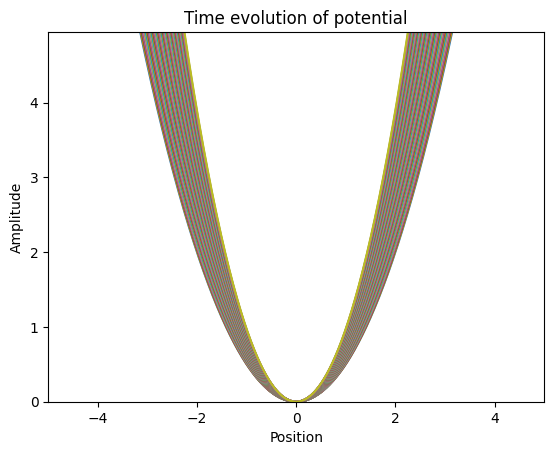

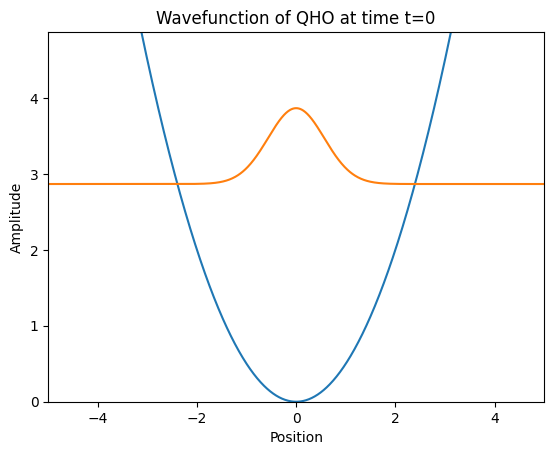

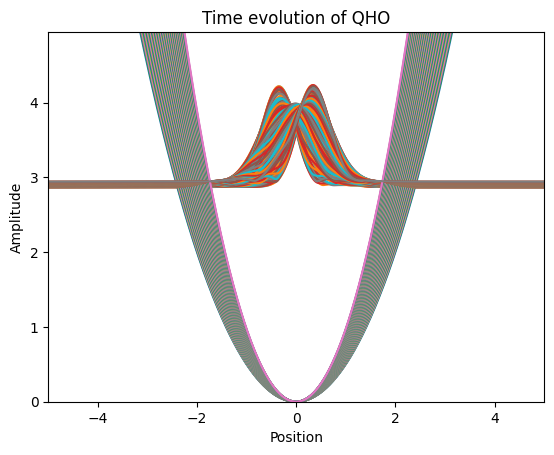

In [19]:
# Applying CN algorithm to solve TDSE
# This is looped for every time step in order to apply the effects of the
# potential at that particular point in time.

### For time-dependent potentials ###
if type(w)==np.ndarray:
    # Plotting time evolution of potential
    plt.figure()
    for j in range(len(t)-1):
        plt.plot(x,V[j,:])
        plt.ylim([0,2+exp_H[j]])
        plt.xlim([-L/2,L/2])
        plt.xlabel('Position')
        plt.ylabel('Amplitude')
        plt.title('Time evolution of potential')
    plt.show()
    for k in range(len(t)-1):
        wfxn_sol=CN_TDSE(V[k,:],wfxn,tau,h,t,x,N)

    # Displaying results
    
    plt.figure()
    # Plotting initial wavefunction inside initial potential
    plt.plot(x,V[0,:])
    plt.plot(x,np.abs(wfxn)+exp_H[0])
    plt.ylim([0,2+exp_H[0]])
    plt.xlim([-L/2, L/2])
    plt.xlabel('Position')
    plt.ylabel('Amplitude')
    plt.title('Wavefunction of QHO at time t=0')
    plt.show()
    
    plt.figure()
    # Plotting all timesteps at once on different plots (animation)
    # Best to plot in plotting window...
    for j in range(len(t)-1):
        plt.plot(x,V[j,:])
        plt.ylim([0,2+exp_H[j]])
        plt.xlim([-L/2,L/2])
        plt.plot(x,np.abs(wfxn_sol[:,j])+exp_H[j])
        plt.xlabel('Position')
        plt.ylabel('Amplitude')
        plt.title('Time evolution of QHO')
    plt.show()

### For time-independent potentials ###
elif type(w)==int:
    V=np.squeeze(np.asarray(V))
    wfxn_sol=CN_TDSE(V,wfxn,tau,h,t,x,N)
    
    # Displaying results
    
    plt.figure()
    # Plotting initial wavefunction inside initial potential
    plt.plot(x,V)
    plt.plot(x,np.abs(wfxn)+exp_H)
    plt.ylim([0,2+exp_H])
    plt.xlim([-L/2, L/2])
    plt.xlabel('Position')
    plt.ylabel('Amplitude')
    plt.title('Wavefunction of QHO at time t=0')
    plt.show()
    
    plt.figure()
    # Plotting all timesteps at once on the same plot
    for j in range(len(t)-1):
        plt.plot(x,V)
        plt.ylim([0,2+exp_H])
        plt.xlim([-L/2,L/2])
        plt.plot(x,np.abs(wfxn_sol[:,j])+exp_H)
        plt.xlabel('Position')
        plt.ylabel('Amplitude')
        plt.title('Time evolution of QHO')
    plt.show()

Checking if wfxn is still normalized...
Total probability: 1.0


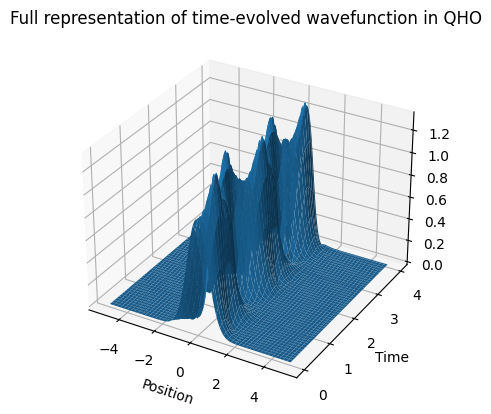

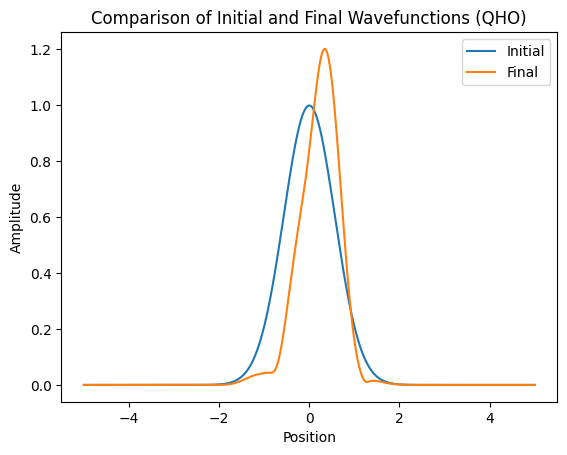

In [20]:
# Checking if time-evolution retained normalization of function at the end
# This allows us to validate the model and ensure it is not broken
print(r"Checking if wfxn is still normalized...")
S=nm.simpson(N,x,wfxn_sol[:,-1]*np.conj(wfxn_sol[:,-1]),-L/2,L/2)
print("Total probability:",'{:,.5}'.format(np.real(S)))

# Plotting the wavefunction on time and spatial axes
X,Y=np.meshgrid(x,t)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, np.abs(wfxn_sol[:,:].transpose()))
plt.xlabel('Position')
plt.ylabel('Time')
plt.title('Full representation of time-evolved wavefunction in QHO')

plt.figure()
plt.plot(x,np.abs(wfxn_sol[:,0]),label='Initial')
plt.plot(x,np.abs(wfxn_sol[:,-1]),label='Final')
plt.xlabel('Position')
plt.ylabel('Amplitude')
plt.title('Comparison of Initial and Final Wavefunctions (QHO)')
plt.legend()